# HydroSOS Streamflow Status Product Methodology
#### Jose Valles (jose.valles.leon@gmail.com)

## One month status product

### Importing the data and finding missing dates

In [1]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

Import de daily discharge from a hydrological station located in Uruguay 

In [2]:
DISCHARGE_DAILY = pd.read_csv('../data/fraymarcos_caudales.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")

Identify the missing dates and change dataframe columns name

In [3]:
# Identify the missing data from a date range (1980 to 2023)
DISCHARGE_DAILY_date_missing = pd.date_range(start = '1980-01-01', end = '2023-03-03',freq='D')
# Re-index the dataframe based on the missind date variable
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
# Set index Fecha
DISCHARGE_DAILY.index.name = 'date' 
# Change columns names
DISCHARGE_DAILY.columns = ['station','discharge']
# Remove station code column
DISCHARGE_DAILY = DISCHARGE_DAILY.drop(columns='station')
# Print the last 6 values
HTML(DISCHARGE_DAILY.tail(6).to_html())

,discharge
date,
2023-02-26,0.802
2023-02-27,0.771
2023-02-28,0.745
2023-03-01,0.729
2023-03-02,0.735
2023-03-03,0.734


We can visualize in a plot the daily discharge from the imported station

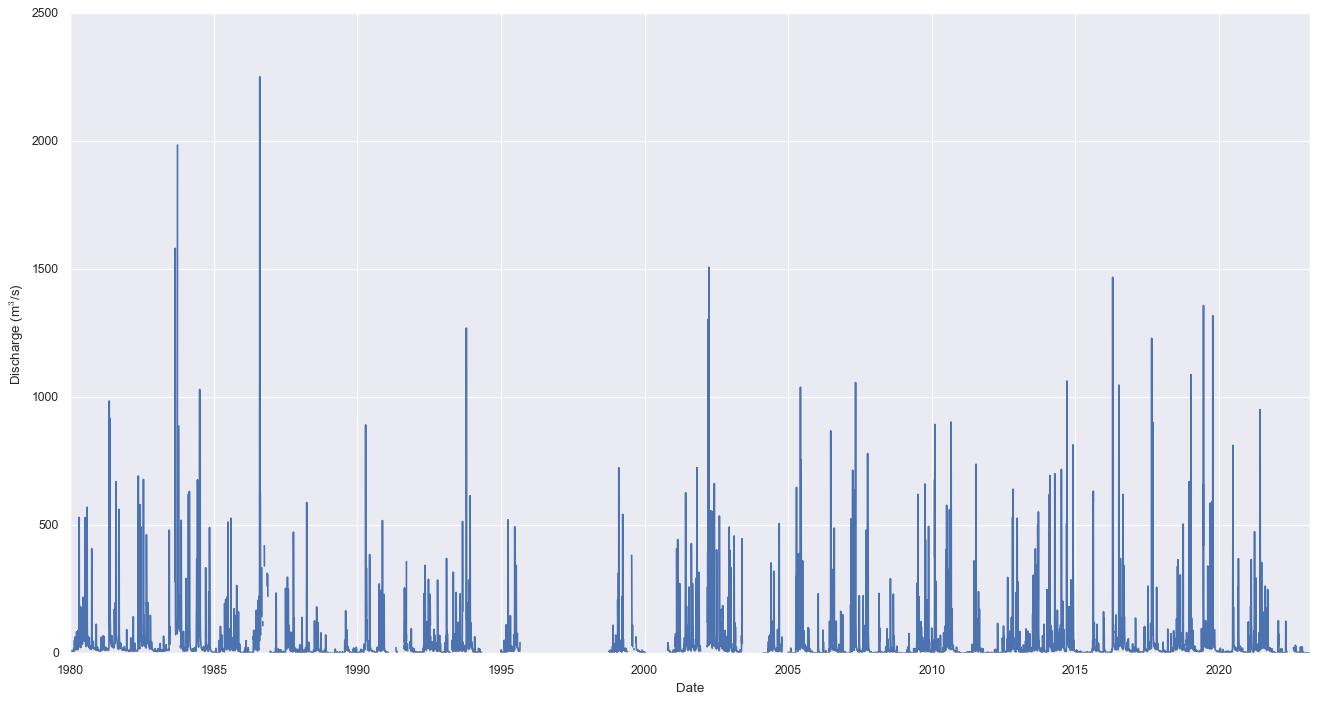

In [4]:
ax1 = DISCHARGE_DAILY['discharge'].plot(figsize=(20, 10));
ax1.set_xlabel('Date');
ax1.set_ylabel('Discharge (m$^3$/s)');

### Calculate monthly mean from daily data

First, we define a percentage of missing value. For this exercise, we use a 50% of missing data in the given month

In [5]:
# Percentage of missing data
max_pct_missing = 50

In [6]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1)
NUMBER_MISSING = NUMBER_MISSING.to_frame()

# change the column name to "missing"
NUMBER_MISSING.columns = ['number_missing'] 

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1) < max_pct_missing
BOOL_MISSING = BOOL_MISSING.to_frame() # Convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

# BOOL_MISSING[~BOOL_MISSING['missing']] # print the dates that does not fulfill the criterion of null data in for each month
# BOOL_MISSING.to_clipboard()

# NUMBER_MISSING.to_clipboard() # Uncomment if you want to visualize all the result in a CSV

Next, we identify the months which contains lower that the max_pct_missing value and the monthly flow is only calculated if 50% o more of recorded value in a given month

In [7]:
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M').apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month < 4, DISCHARGE_MONTHLY.index.year + 1)
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# The water year for this region starts in April (4)
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month < 4, DISCHARGE_DAILY.index.year + 1)
## print the first results
HTML(DISCHARGE_MONTHLY.head(6).to_html(index=False))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

discharge,year,month,water_year
8.646161,1980,1,1980
14.756828,1980,2,1980
30.993548,1980,3,1980
68.594033,1980,4,1981
53.190742,1980,5,1981
88.343367,1980,6,1981


### Select the period of record to estimate the percentage of average. 

For this section, we will use the period 1991-2020 which is the same as climatology

In [8]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1991) & (DISCHARGE_MONTHLY['year'] < 2021)]

Calculate the average dischare for each month in the period of record (e.g. 1991-2020)

In [9]:
DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['discharge'])

print the monthly average discharge 

In [10]:
HTML(DISCHARGE_AVERAGE.to_html())

,discharge
month,
1,16.185548
2,33.987648
3,29.925858
4,34.925943
5,31.424999
6,59.097474
7,58.831931
8,55.527748
9,55.752959


After this, we calculate the following variables 
1. we calculate the monthly mean discharge as a percentage of average
2. we rank the percentage of average of the current month 
3. we count the notnull values of the current month

In [11]:
# create empty columns in the dataframe
DISCHARGE_MONTHLY['average_percentage'] = np.nan
DISCHARGE_MONTHLY['rank_average'] = np.nan
DISCHARGE_MONTHLY['non_missing'] = np.nan

for i in range(len(DISCHARGE_MONTHLY)):
    # Extract the current month 
    m = DISCHARGE_MONTHLY.month[i]
    # Extract the current year
    y = DISCHARGE_MONTHLY.year[i]
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'rank_average']  = DISCHARGE_MONTHLY.query('month==@m')['discharge'].rank()
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'non_missing']  = DISCHARGE_MONTHLY.query('month==@m')["discharge"].notnull().sum()
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'average_percentage'] = (DISCHARGE_MONTHLY['discharge'][i] - DISCHARGE_AVERAGE.query('month == @m')["discharge"].item()) / DISCHARGE_AVERAGE.query('month == @m')["discharge"].item()

### Calculate the percentile using Weibull formula

Calculate the percentile using this formula

$$
\ percentile = \frac{i}{N+1}
$$ 


where _i_ is the rank of the current month and _N_ is the number of months in the period of record 

In [18]:
DISCHARGE_MONTHLY['percentile'] = DISCHARGE_MONTHLY['rank_average']/(DISCHARGE_MONTHLY['non_missing']+1)

print the results

In [24]:
HTML(DISCHARGE_MONTHLY.tail(5).to_html())

,discharge,year,month,water_year,average_percentage,rank_average,non_missing,percentile,Percentile_range,rank_average_percentage
date,,,,,,,,,,
2022-11-30,8.174467,2022,11,2023,-0.626958,12.0,36.0,0.220932,Below normal,12.0
2022-12-31,2.383414,2022,12,2023,-0.901051,5.0,35.0,0.066206,Low flow,5.0
2023-01-31,0.893300,2023,1,2023,-0.944809,5.0,38.0,0.022905,Low flow,5.0
2023-02-28,0.715704,2023,2,2023,-0.978942,3.0,37.0,0.018834,Low flow,3.0
2023-03-31,0.732667,2023,3,2023,-0.975517,2.0,39.0,0.018317,Low flow,2.0


### Assign the percentile to a category

| Category | Percentile Range |
| :- | :-: |
| High flow | 0.870000 - 1.000000 |
| Above normal | 0.720000 - 0.869999 |
| Normal range | 0.280000 - 0.719999 |
| Below normal | 0.130000 - 0.279999 |
| Low flow | 0.000000 - 0.129999 |

In [20]:
criteria = [DISCHARGE_MONTHLY['percentile'].between(0.87,1.00),
            DISCHARGE_MONTHLY['percentile'].between(0.72,0.87),
            DISCHARGE_MONTHLY['percentile'].between(0.28,0.72),
            DISCHARGE_MONTHLY['percentile'].between(0.13,0.28),
            DISCHARGE_MONTHLY['percentile'].between(0.00,0.13)]

values = ['High flow','Above normal','Normal range','Below normal','Low flow']

DISCHARGE_MONTHLY['Percentile_range'] = np.select(criteria,values,0)

Print the results

In [21]:
HTML(DISCHARGE_MONTHLY.tail(5).to_html())

,discharge,year,month,water_year,average_percentage,rank_average,non_missing,percentile,Percentile_range
date,,,,,,,,,
2022-11-30,8.174467,2022,11,2023,-0.626958,12.0,36.0,0.220932,Below normal
2022-12-31,2.383414,2022,12,2023,-0.901051,5.0,35.0,0.066206,Low flow
2023-01-31,0.893300,2023,1,2023,-0.944809,5.0,38.0,0.022905,Low flow
2023-02-28,0.715704,2023,2,2023,-0.978942,3.0,37.0,0.018834,Low flow
2023-03-31,0.732667,2023,3,2023,-0.975517,2.0,39.0,0.018317,Low flow


In [25]:
DISCHARGE_MONTHLY.to_clipboard()